<a href="https://colab.research.google.com/github/velasoka-repo/EVA4/blob/master/Session-6/EVA4_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Github Link](https://github.com/velasoka-repo/EVA4/blob/master/Session-6/EVA4_S6.ipynb)

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary

%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

Applying following three transformation

1.   Compose - group multiple transform into sequential transform
2.   ToTensor - Convert numpy | PILImage to tensor and convert range between 0-1 
`(i.e) array/255`
3. Normalize - input data(train & test) is normalized besed on `mean` & `std` 
`(i.e) (i'th value - mean)/std => final i'th range becomes (-1, 1)`
4. Slight RandomRotate (right to left rotate)

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=(-10, 20), fill=(1, )),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [17]:
SEED = 6

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Training and Testing

In [0]:
def no_loss(model, loss, batch_size):
  return loss

lamda = 0.1
def l1_regularization(model, loss, batch_size):
  value = 0
  for param in model.parameters():
    value += param.abs().sum()
  return (1/batch_size) * (loss.pow(2) + lamda * value)

def l1_regularization_other(model, loss, batch_size):
  value = 0
  for param in model.parameters():
    value += param.abs().sum()
  return loss + 0.001 * value

In [0]:
def train(model, device, train_loader, optimizer, epoch, train_repo, loss_fn):
  train_losses, train_acc = train_repo
  model.train()
  pbar = tqdm(iterable=train_loader, total=len(train_loader), position=0)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    loss = loss_fn(model, loss, len(target))

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def find_misclassified_image(data, labels, output):
    wrong_images = []
    output = output.reshape(len(labels), -1)
    output = output.squeeze()
    for i in range(len(labels)):
      if not torch.eq(labels[i], output[i]):
        wrong_images.append((data[i], labels[i], output[i]))
    
    return wrong_images


def test(model, device, test_loader, test_repo):
    misclassified_img = []
    test_losses, test_acc = test_repo
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            misclassified_img += find_misclassified_image(data, target, pred)


    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return misclassified_img

# Draw Accuracy Graph

In [0]:
def draw_accuracy(train_repo, test_repo, title=""):
  train_losses, train_acc = train_repo
  test_losses, test_acc = test_repo
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title(f"{title} Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title(f"{title} Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title(f"{title} Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title(f"{title} Test Accuracy")

# Image Draw Function

In [0]:
def show_image(data):
  plt.figure(figsize=(14, 16))
  for i in range(25):
    axis = plt.subplot(5, 5, i+1)
    plt.axis('off')
    img, label, pred = data[i]
    axis.set_title(f'Original: {label.item()}\nPredicted: {pred.item()}')
    img = img.cpu().squeeze().numpy()
    plt.imshow(img)

# Training Model

In [0]:
class Net(nn.Module):
    def __init__(self, fm_size):
        super(Net, self).__init__()
        self.fm_size = fm_size
        self.num_classes = 10
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 24

        # self.fm_size *=2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.2), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.2)),
        ) # output_size = 22
        
        self.fm_size = int(self.fm_size*1.2)
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size/1.2), kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size/1.2)),
        ) # output_size = 11

        self.fm_size = int(self.fm_size/1.2)
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 9

        # self.fm_size *=2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.5), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.5)),
        ) # output_size = 7

        self.fm_size = int(self.fm_size*1.5)
        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.num_classes, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.num_classes),
        ) # output_size = 7

        self.avg = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_classes, out_channels=self.num_classes, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)

        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.avg(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model Params

In [23]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Available device: {device}")
model = Net(14).to(device)
summary(model, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
            Conv2d-4           [-1, 14, 24, 24]           1,764
              ReLU-5           [-1, 14, 24, 24]               0
       BatchNorm2d-6           [-1, 14, 24, 24]              28
            Conv2d-7           [-1, 16, 22, 22]           2,016
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 13, 11, 11]             208
             ReLU-12           [-1, 13, 11, 11]               0
      BatchNorm2d-13           [-1, 13, 11, 11]              26
           Conv2

# Train and test our model

In [0]:
def run_model(model, epochs, loss_fn, optimizer, title=""):
  scheduler = StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
  # scheduler = MultiStepLR(optimizer=optimizer, milestones=[5, 8, 11, ], gamma=0.12)
  test_repo = ([], [])
  train_repo = ([], [])
  misclassified_img = []
  for epoch in range(1, epochs+1):
      print(f"EPOCH: {epoch}, *Applied LR: {scheduler.get_lr()}")
      train(model, device, train_loader, optimizer, epoch, train_repo, loss_fn)
      misclassified_img = test(model, device, test_loader, test_repo)
      scheduler.step()

  print("-"*75)
  draw_accuracy(train_repo, test_repo, title)
  return misclassified_img

# L1 & L2 Regularization Model
* Mean Absolute & Squared Error

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1, *Applied LR: [0.01]


Loss=0.43448391556739807 Batch_id=468 Accuracy=90.17: 100%|██████████| 469/469 [00:15<00:00, 31.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1088, Accuracy: 9721/10000 (97.21%)

EPOCH: 2, *Applied LR: [0.01]


Loss=0.39049163460731506 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0749, Accuracy: 9826/10000 (98.26%)

EPOCH: 3, *Applied LR: [0.01]


Loss=0.3525683283805847 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0716, Accuracy: 9810/10000 (98.10%)

EPOCH: 4, *Applied LR: [0.01]


Loss=0.4347769021987915 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:14<00:00, 31.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0777, Accuracy: 9793/10000 (97.93%)

EPOCH: 5, *Applied LR: [0.01]


Loss=0.37912338972091675 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1028, Accuracy: 9723/10000 (97.23%)

EPOCH: 6, *Applied LR: [0.01]


Loss=0.29134470224380493 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:14<00:00, 31.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0746, Accuracy: 9814/10000 (98.14%)

EPOCH: 7, *Applied LR: [0.01]


Loss=0.31630975008010864 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:14<00:00, 31.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0938, Accuracy: 9735/10000 (97.35%)

EPOCH: 8, *Applied LR: [0.01]


Loss=0.27993661165237427 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1321, Accuracy: 9588/10000 (95.88%)

EPOCH: 9, *Applied LR: [0.01]


Loss=0.2468648999929428 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9840/10000 (98.40%)

EPOCH: 10, *Applied LR: [0.01]


Loss=0.28284984827041626 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:14<00:00, 31.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0709, Accuracy: 9790/10000 (97.90%)

EPOCH: 11, *Applied LR: [0.0001]


Loss=0.2328098714351654 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 32.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9927/10000 (99.27%)

EPOCH: 12, *Applied LR: [0.001]


Loss=0.21163581311702728 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9925/10000 (99.25%)

EPOCH: 13, *Applied LR: [0.001]


Loss=0.24082036316394806 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9920/10000 (99.20%)

EPOCH: 14, *Applied LR: [0.001]


Loss=0.19049902260303497 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 32.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9916/10000 (99.16%)

EPOCH: 15, *Applied LR: [0.001]


Loss=0.19242440164089203 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9923/10000 (99.23%)

EPOCH: 16, *Applied LR: [0.001]


Loss=0.1643753945827484 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 32.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9926/10000 (99.26%)

EPOCH: 17, *Applied LR: [0.001]


Loss=0.21719259023666382 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9923/10000 (99.23%)

EPOCH: 18, *Applied LR: [0.001]


Loss=0.1811094582080841 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 32.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9921/10000 (99.21%)

EPOCH: 19, *Applied LR: [0.001]


Loss=0.17922420799732208 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9891/10000 (98.91%)

EPOCH: 20, *Applied LR: [0.001]


Loss=0.16862133145332336 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 32.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9914/10000 (99.14%)

EPOCH: 21, *Applied LR: [1e-05]


Loss=0.19662731885910034 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9941/10000 (99.41%)

EPOCH: 22, *Applied LR: [0.0001]


Loss=0.15376457571983337 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9944/10000 (99.44%)

EPOCH: 23, *Applied LR: [0.0001]


Loss=0.1655927300453186 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9938/10000 (99.38%)

EPOCH: 24, *Applied LR: [0.0001]


Loss=0.14635403454303741 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9939/10000 (99.39%)

EPOCH: 25, *Applied LR: [0.0001]


Loss=0.14017613232135773 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9946/10000 (99.46%)

EPOCH: 26, *Applied LR: [0.0001]


Loss=0.1645643562078476 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9944/10000 (99.44%)

EPOCH: 27, *Applied LR: [0.0001]


Loss=0.13801392912864685 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9944/10000 (99.44%)

EPOCH: 28, *Applied LR: [0.0001]


Loss=0.16496214270591736 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9937/10000 (99.37%)

EPOCH: 29, *Applied LR: [0.0001]


Loss=0.13032710552215576 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9951/10000 (99.51%)

EPOCH: 30, *Applied LR: [0.0001]


Loss=0.13562868535518646 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9941/10000 (99.41%)

EPOCH: 31, *Applied LR: [1.0000000000000002e-06]


Loss=0.12943585216999054 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9951/10000 (99.51%)

EPOCH: 32, *Applied LR: [1e-05]


Loss=0.12752477824687958 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9950/10000 (99.50%)

EPOCH: 33, *Applied LR: [1e-05]


Loss=0.14850187301635742 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9948/10000 (99.48%)

EPOCH: 34, *Applied LR: [1e-05]


Loss=0.13759440183639526 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9948/10000 (99.48%)

EPOCH: 35, *Applied LR: [1e-05]


Loss=0.13149189949035645 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]



Test set: Average loss: 0.0216, Accuracy: 9945/10000 (99.45%)

EPOCH: 36, *Applied LR: [1e-05]


Loss=0.18535378575325012 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9947/10000 (99.47%)

EPOCH: 37, *Applied LR: [1e-05]


Loss=0.17296360433101654 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9948/10000 (99.48%)

EPOCH: 38, *Applied LR: [1e-05]


Loss=0.17009897530078888 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9948/10000 (99.48%)

EPOCH: 39, *Applied LR: [1e-05]


Loss=0.13842818140983582 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 33.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9947/10000 (99.47%)

EPOCH: 40, *Applied LR: [1e-05]


Loss=0.15477848052978516 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]



Test set: Average loss: 0.0215, Accuracy: 9948/10000 (99.48%)

---------------------------------------------------------------------------


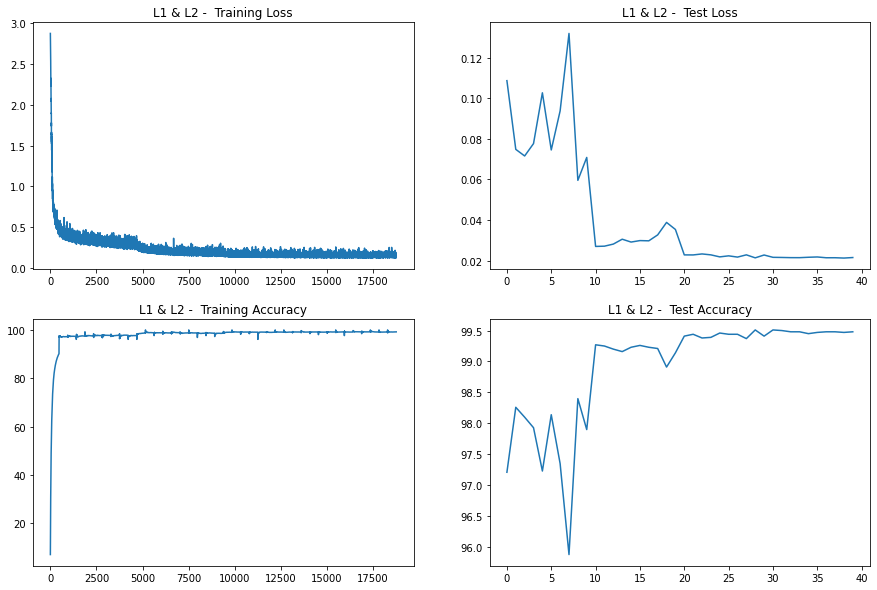

In [42]:
model =  Net(14).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
l1_l2_misclassified_img = run_model(model, 40, l1_regularization_other, optimizer, "L1 & L2 - ")

### L1 & L2 Model Mis-Classified Image

Loss=0.041427504271268845 Batch_id=366 Accuracy=10.44:  78%|███████▊  | 365/469 [18:46<05:21,  3.09s/it]


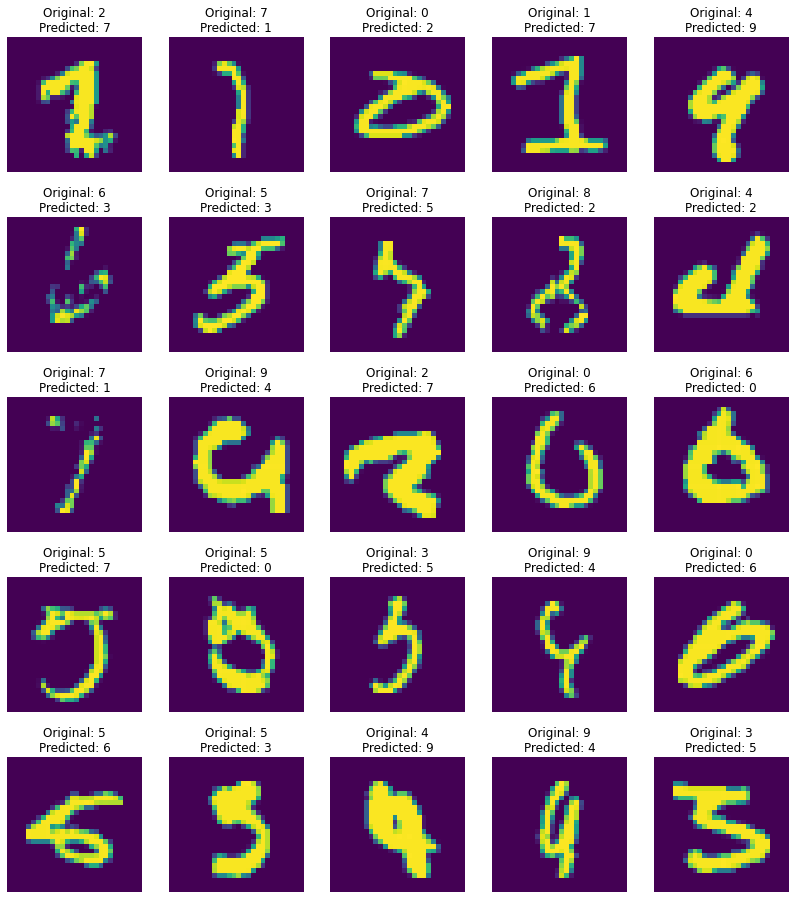

In [43]:
show_image(l1_l2_misclassified_img)

# L2 Regularization Model
* Mean Squared Error

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1, *Applied LR: [0.01]


Loss=0.622692883014679 Batch_id=468 Accuracy=84.22: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7931, Accuracy: 9372/10000 (93.72%)

EPOCH: 2, *Applied LR: [0.01]


Loss=0.625188946723938 Batch_id=468 Accuracy=95.61: 100%|██████████| 469/469 [00:13<00:00, 34.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7532, Accuracy: 9553/10000 (95.53%)

EPOCH: 3, *Applied LR: [0.01]


Loss=0.5557258725166321 Batch_id=468 Accuracy=95.99: 100%|██████████| 469/469 [00:13<00:00, 34.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6210, Accuracy: 9494/10000 (94.94%)

EPOCH: 4, *Applied LR: [0.01]


Loss=0.5962019562721252 Batch_id=468 Accuracy=95.98: 100%|██████████| 469/469 [00:13<00:00, 35.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5718, Accuracy: 9672/10000 (96.72%)

EPOCH: 5, *Applied LR: [0.01]


Loss=0.5879462361335754 Batch_id=468 Accuracy=96.07: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6447, Accuracy: 9373/10000 (93.73%)

EPOCH: 6, *Applied LR: [0.01]


Loss=0.5841105580329895 Batch_id=468 Accuracy=96.04: 100%|██████████| 469/469 [00:13<00:00, 35.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7358, Accuracy: 9342/10000 (93.42%)

EPOCH: 7, *Applied LR: [0.01]


Loss=0.5728010535240173 Batch_id=468 Accuracy=96.11: 100%|██████████| 469/469 [00:13<00:00, 34.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5544, Accuracy: 9609/10000 (96.09%)

EPOCH: 8, *Applied LR: [0.01]


Loss=0.5607762932777405 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6190, Accuracy: 9321/10000 (93.21%)

EPOCH: 9, *Applied LR: [0.01]


Loss=0.5418605208396912 Batch_id=468 Accuracy=96.15: 100%|██████████| 469/469 [00:13<00:00, 35.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5620, Accuracy: 9683/10000 (96.83%)

EPOCH: 10, *Applied LR: [0.01]


Loss=0.5680121779441833 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:13<00:00, 35.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6178, Accuracy: 9321/10000 (93.21%)

EPOCH: 11, *Applied LR: [0.0001]


Loss=0.4897126853466034 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:13<00:00, 33.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4319, Accuracy: 9848/10000 (98.48%)

EPOCH: 12, *Applied LR: [0.001]


Loss=0.45969071984291077 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4039, Accuracy: 9853/10000 (98.53%)

EPOCH: 13, *Applied LR: [0.001]


Loss=0.4961108863353729 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4255, Accuracy: 9879/10000 (98.79%)

EPOCH: 14, *Applied LR: [0.001]


Loss=0.4726187288761139 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:13<00:00, 34.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4607, Accuracy: 9796/10000 (97.96%)

EPOCH: 15, *Applied LR: [0.001]


Loss=0.49259746074676514 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 34.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4379, Accuracy: 9865/10000 (98.65%)

EPOCH: 16, *Applied LR: [0.001]


Loss=0.4520628750324249 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3975, Accuracy: 9861/10000 (98.61%)

EPOCH: 17, *Applied LR: [0.001]


Loss=0.4645098149776459 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:13<00:00, 34.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4544, Accuracy: 9854/10000 (98.54%)

EPOCH: 18, *Applied LR: [0.001]


Loss=0.456619530916214 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4060, Accuracy: 9892/10000 (98.92%)

EPOCH: 19, *Applied LR: [0.001]


Loss=0.434025377035141 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:13<00:00, 35.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4227, Accuracy: 9872/10000 (98.72%)

EPOCH: 20, *Applied LR: [0.001]


Loss=0.43683359026908875 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4070, Accuracy: 9896/10000 (98.96%)

EPOCH: 21, *Applied LR: [1e-05]


Loss=0.44370174407958984 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:13<00:00, 34.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3874, Accuracy: 9910/10000 (99.10%)

EPOCH: 22, *Applied LR: [0.0001]


Loss=0.44592490792274475 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3860, Accuracy: 9919/10000 (99.19%)

EPOCH: 23, *Applied LR: [0.0001]


Loss=0.4511542320251465 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3877, Accuracy: 9926/10000 (99.26%)

EPOCH: 24, *Applied LR: [0.0001]


Loss=0.4643137753009796 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3889, Accuracy: 9908/10000 (99.08%)

EPOCH: 25, *Applied LR: [0.0001]


Loss=0.4628017842769623 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3817, Accuracy: 9905/10000 (99.05%)

EPOCH: 26, *Applied LR: [0.0001]


Loss=0.4561958611011505 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3904, Accuracy: 9910/10000 (99.10%)

EPOCH: 27, *Applied LR: [0.0001]


Loss=0.45135965943336487 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3775, Accuracy: 9905/10000 (99.05%)

EPOCH: 28, *Applied LR: [0.0001]


Loss=0.46268197894096375 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:14<00:00, 32.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3866, Accuracy: 9919/10000 (99.19%)

EPOCH: 29, *Applied LR: [0.0001]


Loss=0.39565959572792053 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3885, Accuracy: 9907/10000 (99.07%)

EPOCH: 30, *Applied LR: [0.0001]


Loss=0.4644024074077606 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 33.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3832, Accuracy: 9913/10000 (99.13%)

EPOCH: 31, *Applied LR: [1.0000000000000002e-06]


Loss=0.49957263469696045 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3828, Accuracy: 9925/10000 (99.25%)

EPOCH: 32, *Applied LR: [1e-05]


Loss=0.4302767813205719 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3851, Accuracy: 9921/10000 (99.21%)

EPOCH: 33, *Applied LR: [1e-05]


Loss=0.48336061835289 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 32.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3778, Accuracy: 9924/10000 (99.24%)

EPOCH: 34, *Applied LR: [1e-05]


Loss=0.44915568828582764 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3816, Accuracy: 9920/10000 (99.20%)

EPOCH: 35, *Applied LR: [1e-05]


Loss=0.49532973766326904 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 32.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3796, Accuracy: 9919/10000 (99.19%)

EPOCH: 36, *Applied LR: [1e-05]


Loss=0.46832942962646484 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 32.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3788, Accuracy: 9925/10000 (99.25%)

EPOCH: 37, *Applied LR: [1e-05]


Loss=0.4866461753845215 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3803, Accuracy: 9923/10000 (99.23%)

EPOCH: 38, *Applied LR: [1e-05]


Loss=0.4322345554828644 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3812, Accuracy: 9922/10000 (99.22%)

EPOCH: 39, *Applied LR: [1e-05]


Loss=0.4503093957901001 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3809, Accuracy: 9919/10000 (99.19%)

EPOCH: 40, *Applied LR: [1e-05]


Loss=0.450120210647583 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s]



Test set: Average loss: 0.3785, Accuracy: 9923/10000 (99.23%)

---------------------------------------------------------------------------


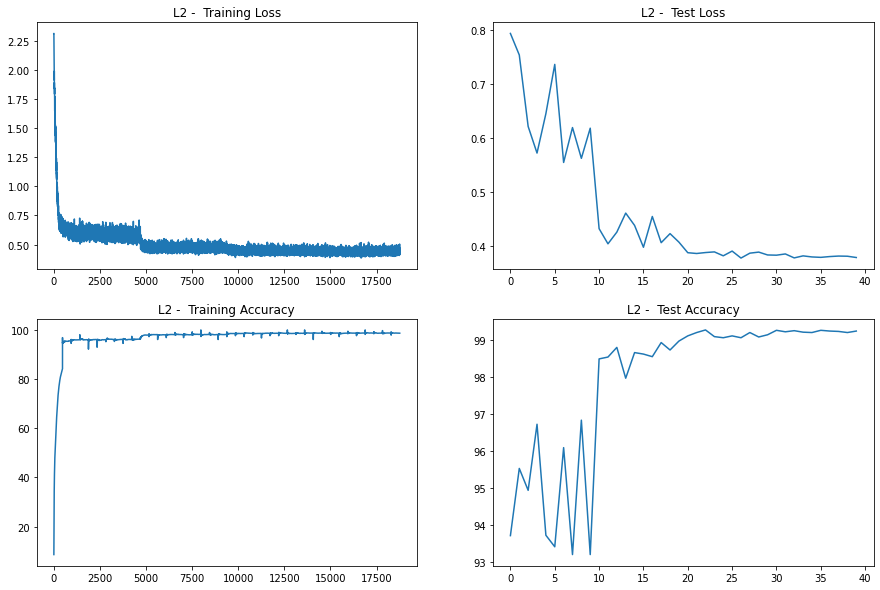

In [29]:
model =  Net(14).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.1)
l2_misclassified_img = run_model(model, 40, no_loss, optimizer, "L2 - ")

### L2 Model: Mis-classified Image

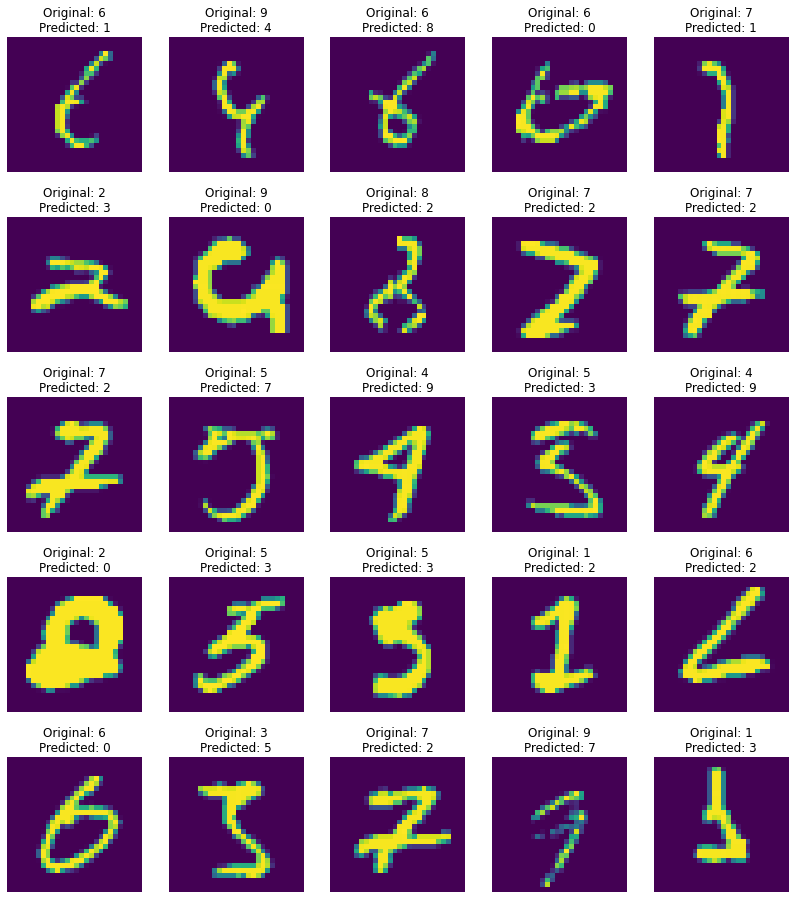

In [30]:
show_image(l2_misclassified_img)

# L1 Regularization Model
* Mean Absolute Error

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1, *Applied LR: [0.01]


Loss=0.3345987796783447 Batch_id=468 Accuracy=49.20: 100%|██████████| 469/469 [00:18<00:00, 25.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.7318, Accuracy: 6925/10000 (69.25%)

EPOCH: 2, *Applied LR: [0.01]


Loss=0.18091893196105957 Batch_id=468 Accuracy=75.77: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.4082, Accuracy: 8031/10000 (80.31%)

EPOCH: 3, *Applied LR: [0.01]


Loss=0.14903531968593597 Batch_id=468 Accuracy=86.47: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.1982, Accuracy: 8341/10000 (83.41%)

EPOCH: 4, *Applied LR: [0.01]


Loss=0.13803055882453918 Batch_id=468 Accuracy=88.69: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2226, Accuracy: 8306/10000 (83.06%)

EPOCH: 5, *Applied LR: [0.01]


Loss=0.126382976770401 Batch_id=468 Accuracy=88.14: 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2432, Accuracy: 7628/10000 (76.28%)

EPOCH: 6, *Applied LR: [0.01]


Loss=0.11707225441932678 Batch_id=468 Accuracy=87.31: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0606, Accuracy: 8174/10000 (81.74%)

EPOCH: 7, *Applied LR: [0.01]


Loss=0.11113330721855164 Batch_id=468 Accuracy=86.90: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9896, Accuracy: 8432/10000 (84.32%)

EPOCH: 8, *Applied LR: [0.01]


Loss=0.1066390797495842 Batch_id=468 Accuracy=87.12: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9882, Accuracy: 8464/10000 (84.64%)

EPOCH: 9, *Applied LR: [0.01]


Loss=0.10203015804290771 Batch_id=468 Accuracy=87.09: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0601, Accuracy: 7416/10000 (74.16%)

EPOCH: 10, *Applied LR: [0.01]


Loss=0.09605991095304489 Batch_id=468 Accuracy=87.70: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.8923, Accuracy: 8610/10000 (86.10%)

EPOCH: 11, *Applied LR: [0.0001]


Loss=0.09164834022521973 Batch_id=468 Accuracy=90.72: 100%|██████████| 469/469 [00:15<00:00, 30.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7459, Accuracy: 9012/10000 (90.12%)

EPOCH: 12, *Applied LR: [0.001]


Loss=0.09187687933444977 Batch_id=468 Accuracy=90.57: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7003, Accuracy: 9307/10000 (93.07%)

EPOCH: 13, *Applied LR: [0.001]


Loss=0.09241517633199692 Batch_id=468 Accuracy=90.66: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6721, Accuracy: 9131/10000 (91.31%)

EPOCH: 14, *Applied LR: [0.001]


Loss=0.09051269292831421 Batch_id=468 Accuracy=90.73: 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7572, Accuracy: 8941/10000 (89.41%)

EPOCH: 15, *Applied LR: [0.001]


Loss=0.09115829318761826 Batch_id=468 Accuracy=90.71: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7040, Accuracy: 9438/10000 (94.38%)

EPOCH: 16, *Applied LR: [0.001]


Loss=0.09077289700508118 Batch_id=468 Accuracy=90.89: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6814, Accuracy: 9057/10000 (90.57%)

EPOCH: 17, *Applied LR: [0.001]


Loss=0.08884229511022568 Batch_id=468 Accuracy=90.75: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6925, Accuracy: 8935/10000 (89.35%)

EPOCH: 18, *Applied LR: [0.001]


Loss=0.08913056552410126 Batch_id=468 Accuracy=90.90: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7034, Accuracy: 8886/10000 (88.86%)

EPOCH: 19, *Applied LR: [0.001]


Loss=0.08879502862691879 Batch_id=468 Accuracy=90.63: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6909, Accuracy: 8974/10000 (89.74%)

EPOCH: 20, *Applied LR: [0.001]


Loss=0.08804836124181747 Batch_id=468 Accuracy=90.82: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6682, Accuracy: 9033/10000 (90.33%)

EPOCH: 21, *Applied LR: [1e-05]


Loss=0.08915268629789352 Batch_id=468 Accuracy=91.68: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6554, Accuracy: 9287/10000 (92.87%)

EPOCH: 22, *Applied LR: [0.0001]


Loss=0.08848317712545395 Batch_id=468 Accuracy=91.74: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6463, Accuracy: 9332/10000 (93.32%)

EPOCH: 23, *Applied LR: [0.0001]


Loss=0.08837231993675232 Batch_id=468 Accuracy=91.76: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6459, Accuracy: 9139/10000 (91.39%)

EPOCH: 24, *Applied LR: [0.0001]


Loss=0.08807098865509033 Batch_id=468 Accuracy=91.82: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6488, Accuracy: 9347/10000 (93.47%)

EPOCH: 25, *Applied LR: [0.0001]


Loss=0.08717121183872223 Batch_id=468 Accuracy=91.83: 100%|██████████| 469/469 [00:15<00:00, 30.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6442, Accuracy: 9220/10000 (92.20%)

EPOCH: 26, *Applied LR: [0.0001]


Loss=0.08838268369436264 Batch_id=468 Accuracy=91.81: 100%|██████████| 469/469 [00:15<00:00, 29.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6388, Accuracy: 9252/10000 (92.52%)

EPOCH: 27, *Applied LR: [0.0001]


Loss=0.08989819884300232 Batch_id=468 Accuracy=91.75: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6596, Accuracy: 9273/10000 (92.73%)

EPOCH: 28, *Applied LR: [0.0001]


Loss=0.0880623385310173 Batch_id=468 Accuracy=91.72: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6490, Accuracy: 9258/10000 (92.58%)

EPOCH: 29, *Applied LR: [0.0001]


Loss=0.08730468153953552 Batch_id=468 Accuracy=91.84: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6474, Accuracy: 9300/10000 (93.00%)

EPOCH: 30, *Applied LR: [0.0001]


Loss=0.08670111745595932 Batch_id=468 Accuracy=91.83: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6561, Accuracy: 9198/10000 (91.98%)

EPOCH: 31, *Applied LR: [1.0000000000000002e-06]


Loss=0.08792059868574142 Batch_id=468 Accuracy=91.88: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6379, Accuracy: 9245/10000 (92.45%)

EPOCH: 32, *Applied LR: [1e-05]


Loss=0.0873745009303093 Batch_id=468 Accuracy=91.92: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6380, Accuracy: 9249/10000 (92.49%)

EPOCH: 33, *Applied LR: [1e-05]


Loss=0.08719934523105621 Batch_id=468 Accuracy=91.88: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6490, Accuracy: 9195/10000 (91.95%)

EPOCH: 34, *Applied LR: [1e-05]


Loss=0.08711253106594086 Batch_id=468 Accuracy=91.96: 100%|██████████| 469/469 [00:15<00:00, 29.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6428, Accuracy: 9217/10000 (92.17%)

EPOCH: 35, *Applied LR: [1e-05]


Loss=0.0879846140742302 Batch_id=468 Accuracy=91.86: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6381, Accuracy: 9252/10000 (92.52%)

EPOCH: 36, *Applied LR: [1e-05]


Loss=0.0874108076095581 Batch_id=468 Accuracy=91.98: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6376, Accuracy: 9299/10000 (92.99%)

EPOCH: 37, *Applied LR: [1e-05]


Loss=0.08713538944721222 Batch_id=468 Accuracy=91.93: 100%|██████████| 469/469 [00:16<00:00, 28.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6442, Accuracy: 9302/10000 (93.02%)

EPOCH: 38, *Applied LR: [1e-05]


Loss=0.0873415619134903 Batch_id=468 Accuracy=91.97: 100%|██████████| 469/469 [00:16<00:00, 28.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6425, Accuracy: 9254/10000 (92.54%)

EPOCH: 39, *Applied LR: [1e-05]


Loss=0.08732028305530548 Batch_id=468 Accuracy=91.91: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6435, Accuracy: 9203/10000 (92.03%)

EPOCH: 40, *Applied LR: [1e-05]


Loss=0.08654569089412689 Batch_id=468 Accuracy=91.86: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]



Test set: Average loss: 0.6408, Accuracy: 9196/10000 (91.96%)

---------------------------------------------------------------------------


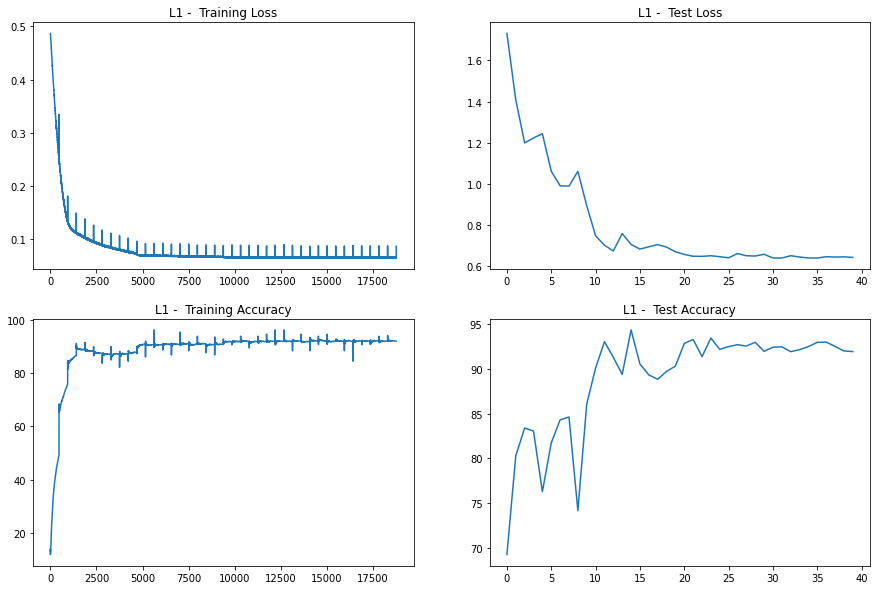

In [31]:
model =  Net(14).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
l1_misclassified_img = run_model(model, 40, l1_regularization, optimizer, "L1 - ")

### L1 Model: Mis-classified Image

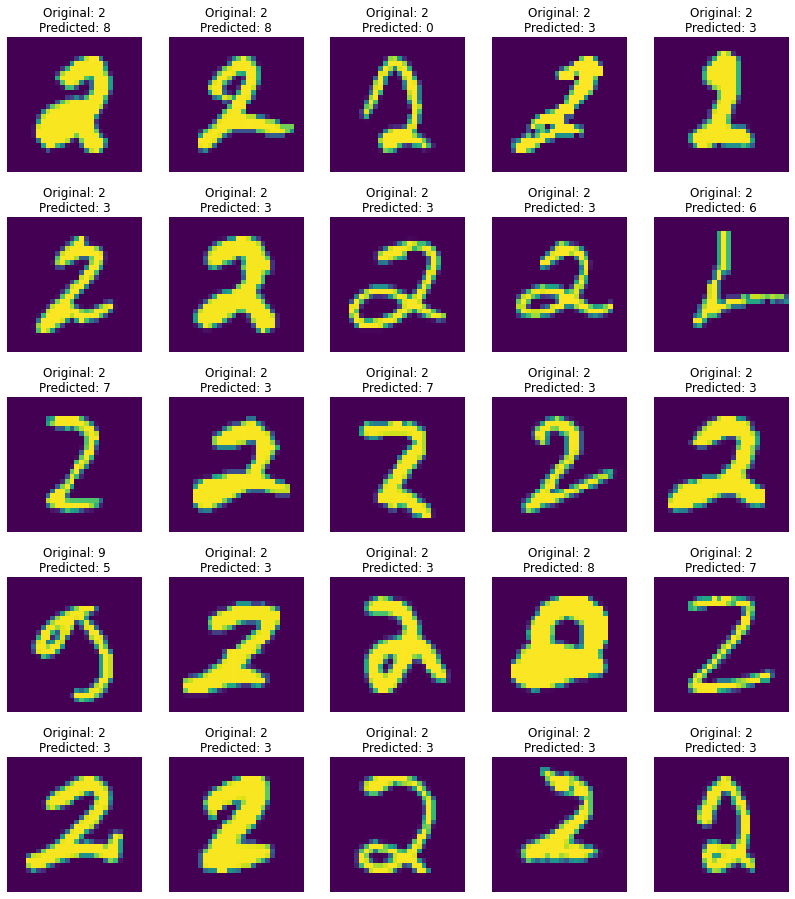

In [32]:
show_image(l1_misclassified_img)

# Default Model Run
* 40 epoch

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1, *Applied LR: [0.01]


Loss=0.10730812698602676 Batch_id=468 Accuracy=88.61: 100%|██████████| 469/469 [00:14<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0637, Accuracy: 9846/10000 (98.46%)

EPOCH: 2, *Applied LR: [0.01]


Loss=0.08887141942977905 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:14<00:00, 31.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9879/10000 (98.79%)

EPOCH: 3, *Applied LR: [0.01]


Loss=0.046066392213106155 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9909/10000 (99.09%)

EPOCH: 4, *Applied LR: [0.01]


Loss=0.018585696816444397 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9933/10000 (99.33%)

EPOCH: 5, *Applied LR: [0.01]


Loss=0.07345884293317795 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9889/10000 (98.89%)

EPOCH: 6, *Applied LR: [0.01]


Loss=0.02830987237393856 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 31.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9919/10000 (99.19%)

EPOCH: 7, *Applied LR: [0.01]


Loss=0.04444661736488342 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 32.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

EPOCH: 8, *Applied LR: [0.01]


Loss=0.018039511516690254 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9926/10000 (99.26%)

EPOCH: 9, *Applied LR: [0.01]


Loss=0.017877787351608276 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 10, *Applied LR: [0.01]


Loss=0.09647782891988754 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9924/10000 (99.24%)

EPOCH: 11, *Applied LR: [0.0001]


Loss=0.010423039086163044 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9937/10000 (99.37%)

EPOCH: 12, *Applied LR: [0.001]


Loss=0.011651796288788319 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 31.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9949/10000 (99.49%)

EPOCH: 13, *Applied LR: [0.001]


Loss=0.05294362083077431 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9946/10000 (99.46%)

EPOCH: 14, *Applied LR: [0.001]


Loss=0.04834498465061188 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9947/10000 (99.47%)

EPOCH: 15, *Applied LR: [0.001]


Loss=0.005852103233337402 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9950/10000 (99.50%)

EPOCH: 16, *Applied LR: [0.001]


Loss=0.02204669453203678 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9950/10000 (99.50%)

EPOCH: 17, *Applied LR: [0.001]


Loss=0.004132171627134085 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:14<00:00, 31.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9949/10000 (99.49%)

EPOCH: 18, *Applied LR: [0.001]


Loss=0.009649832732975483 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9952/10000 (99.52%)

EPOCH: 19, *Applied LR: [0.001]


Loss=0.013014654628932476 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9951/10000 (99.51%)

EPOCH: 20, *Applied LR: [0.001]


Loss=0.01476155687123537 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9952/10000 (99.52%)

EPOCH: 21, *Applied LR: [1e-05]


Loss=0.03852882981300354 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9954/10000 (99.54%)

EPOCH: 22, *Applied LR: [0.0001]


Loss=0.013270723633468151 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:14<00:00, 32.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9954/10000 (99.54%)

EPOCH: 23, *Applied LR: [0.0001]


Loss=0.07942874729633331 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9956/10000 (99.56%)

EPOCH: 24, *Applied LR: [0.0001]


Loss=0.008709301240742207 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9954/10000 (99.54%)

EPOCH: 25, *Applied LR: [0.0001]


Loss=0.024392426013946533 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:14<00:00, 31.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9953/10000 (99.53%)

EPOCH: 26, *Applied LR: [0.0001]


Loss=0.014604136347770691 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9955/10000 (99.55%)

EPOCH: 27, *Applied LR: [0.0001]


Loss=0.006469195242971182 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9953/10000 (99.53%)

EPOCH: 28, *Applied LR: [0.0001]


Loss=0.01286481786519289 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9955/10000 (99.55%)

EPOCH: 29, *Applied LR: [0.0001]


Loss=0.008808419108390808 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9954/10000 (99.54%)

EPOCH: 30, *Applied LR: [0.0001]


Loss=0.016972819343209267 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9955/10000 (99.55%)

EPOCH: 31, *Applied LR: [1.0000000000000002e-06]


Loss=0.057729288935661316 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9950/10000 (99.50%)

EPOCH: 32, *Applied LR: [1e-05]


Loss=0.02773978002369404 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9955/10000 (99.55%)

EPOCH: 33, *Applied LR: [1e-05]


Loss=0.018456364050507545 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9956/10000 (99.56%)

EPOCH: 34, *Applied LR: [1e-05]


Loss=0.02403602935373783 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 33.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9954/10000 (99.54%)

EPOCH: 35, *Applied LR: [1e-05]


Loss=0.02484958805143833 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9955/10000 (99.55%)

EPOCH: 36, *Applied LR: [1e-05]


Loss=0.0031877208966761827 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9956/10000 (99.56%)

EPOCH: 37, *Applied LR: [1e-05]


Loss=0.005088686943054199 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9953/10000 (99.53%)

EPOCH: 38, *Applied LR: [1e-05]


Loss=0.007748082280158997 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9952/10000 (99.52%)

EPOCH: 39, *Applied LR: [1e-05]


Loss=0.003159085987135768 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:15<00:00, 30.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9954/10000 (99.54%)

EPOCH: 40, *Applied LR: [1e-05]


Loss=0.01915900968015194 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]



Test set: Average loss: 0.0164, Accuracy: 9955/10000 (99.55%)

---------------------------------------------------------------------------


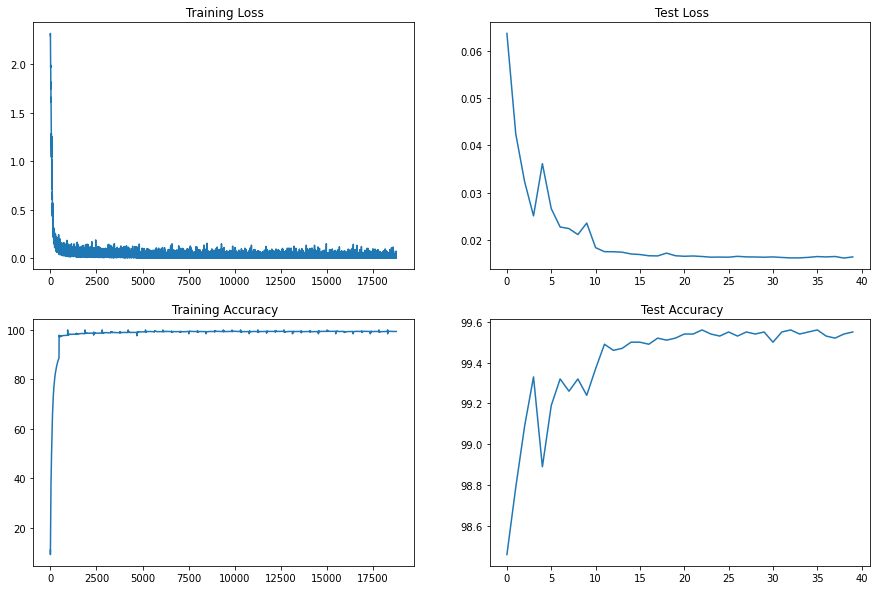

In [33]:
model =  Net(14).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
misclassified_img = run_model(model, 40, no_loss, optimizer)

### Default Model: Mis-classified Image

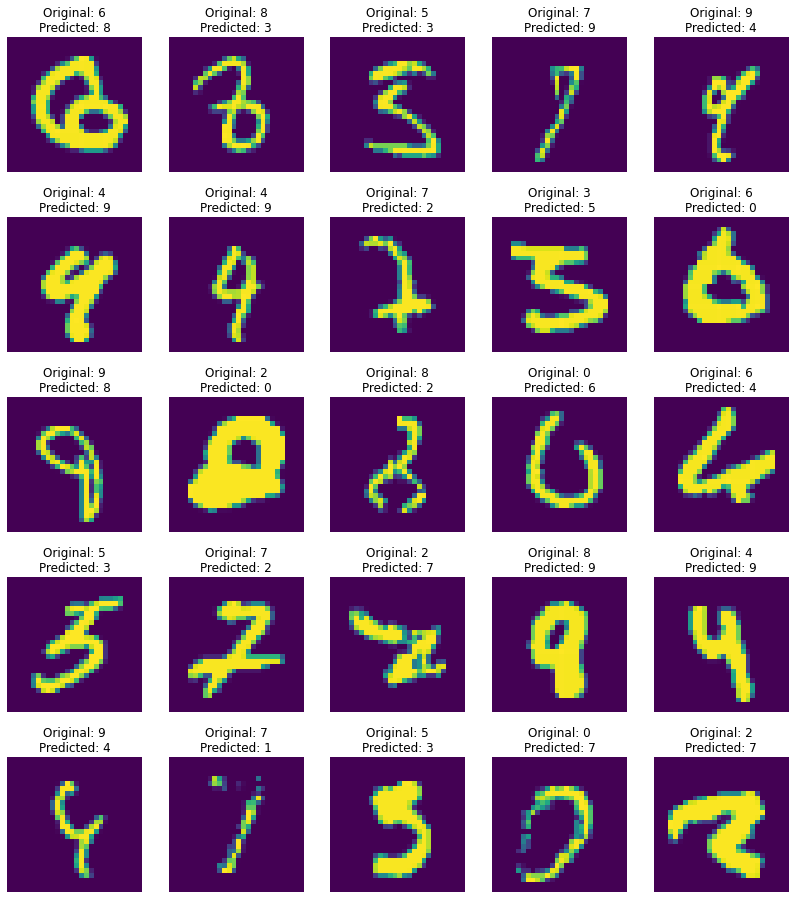

In [34]:
show_image(misclassified_img)